## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)
df = pd.get_dummies(df, prefix=['thal'])
feature_names = df.drop(['target'], axis=1).columns

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

x_train = train_df.drop(['target'], axis=1).values
y_train = train_df['target'].values

x_test = test_df.drop(['target'], axis=1).values
y_test = test_df['target'].values

In [319]:
train_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
136,54,1,2,192,283,0,2,195,0,0.0,1,1,0,0,0,0,0,1
232,58,0,4,170,225,1,2,146,1,2.8,2,2,1,0,0,1,0,0
233,56,1,2,130,221,0,2,163,0,0.0,1,0,0,0,0,0,0,1
184,46,1,4,120,249,0,2,144,0,0.8,1,0,0,0,0,0,0,1
84,55,0,2,135,250,0,2,161,0,1.4,2,0,0,0,0,0,1,0


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [320]:
def gini(y):
    """
    Gini impurity (local entropy) of a label sequence
    """
    hist = np.bincount(y)
    N = np.sum(hist)
    return 1 - sum([(i / N) ** 2 for i in hist])


def entropy(y):
    """
    Entropy of a label sequence
    """
    hist = np.bincount(y)
    ps = hist / np.sum(hist)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [321]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])

In [322]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [323]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [324]:
class DecisionTree:
    def __init__(
        self,
        classifier=True,
        max_depth=None,
        max_features=None,
        criterion="entropy",
        seed=None,
    ):
        if seed:
            np.random.seed(seed)
        self.depth = 0
        self.root = None
        self.max_features = max_features
        self.criterion = criterion
        self.classifier = classifier
        self.max_depth = max_depth if max_depth else np.inf
        self.feature_values = []
        if not classifier and criterion in ["gini", "entropy"]:
            raise ValueError(
                "{} is a valid criterion only when classifier = True.".format(criterion)
            )
        if classifier and criterion == "mse":
            raise ValueError("`mse` is a valid criterion only when classifier = False.")

    def fit(self, X, Y):
        self.n_classes = max(Y) + 1 if self.classifier else None
        self.max_features = X.shape[1] if not self.max_features else min(self.max_features, X.shape[1])
        self.root = self._grow(X, Y)

    def predict(self, X):   
        return np.array([self._traverse(x, self.root) for x in X])

    def predict_class_probs(self, X):
        """
        Use the trained decision tree to return the class probabilities for the
        examples in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features
        Returns
        -------
        preds : :py:class:`ndarray <numpy.ndarray>` of shape `(N, n_classes)`
            The class probabilities predicted for each example in `X`.
        """
        assert self.classifier, "`predict_class_probs` undefined for classifier = False"
        return np.array([self._traverse(x, self.root, prob=True) for x in X])

    def _grow(self, X, Y, cur_depth=0):
        # if all labels are the same, return a leaf
        if len(set(Y)) == 1:
            if self.classifier:
                prob = np.zeros(self.n_classes)
                prob[Y[0]] = 1.0
            return Leaf(prob) if self.classifier else Leaf(Y[0])

        # if we have reached max_depth, return a leaf
        if cur_depth >= self.max_depth:
            v = np.mean(Y, axis=0)
            if self.classifier:
                v = np.bincount(Y, minlength=self.n_classes) / len(Y)
            return Leaf(v)

        cur_depth += 1
        self.depth = max(self.depth, cur_depth)

        N, M = X.shape
        feat_idxs = np.random.choice(M, self.max_features, replace=False)

        # greedily select the best split according to `criterion`
        feat, thresh = self._segment(X, Y, feat_idxs)
        self.feature_values.append(feat)
        l = np.argwhere(X[:, feat] <= thresh).flatten()
        r = np.argwhere(X[:, feat] > thresh).flatten()

        # grow the children that result from the split
        left = self._grow(X[l, :], Y[l], cur_depth)
        right = self._grow(X[r, :], Y[r], cur_depth)
        return Node(left, right, (feat, thresh))

    def _segment(self, X, Y, feat_idxs):
        """
        Find the optimal split rule (feature index and split threshold) for the
        data according to `self.criterion`.
        """
        best_gain = -np.inf
        split_idx, split_thresh = None, None
        for i in feat_idxs:
            vals = X[:, i]    
            levels = np.unique(vals)
            thresholds = (levels[:-1] + levels[1:]) / 2 if len(levels) > 1 else levels
            gains = np.array([self._impurity_gain(Y, t, vals) for t in thresholds])
            if gains.max() > best_gain:
                split_idx = i
                best_gain = gains.max()
                split_thresh = thresholds[gains.argmax()]
        return split_idx, split_thresh

    def _impurity_gain(self, Y, split_thresh, feat_values):
        """
        Compute the impurity gain associated with a given split.
        IG(split) = loss(parent) - weighted_avg[loss(left_child), loss(right_child)]
        """
        if self.criterion == "entropy":
            loss = entropy
        elif self.criterion == "gini":
            loss = gini
        parent_loss = loss(Y)

        # generate split
        left = np.argwhere(feat_values <= split_thresh).flatten()
        right = np.argwhere(feat_values > split_thresh).flatten()

        if len(left) == 0 or len(right) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(Y)
        n_l, n_r = len(left), len(right)
        e_l, e_r = loss(Y[left]), loss(Y[right])
        child_loss = (n_l / n) * e_l + (n_r / n) * e_r

        # impurity gain is difference in loss before vs. after split
        ig = parent_loss - child_loss
        return ig

    def _traverse(self, X, node, prob=False):
        if isinstance(node, Leaf):
            if self.classifier:
                return node.value if prob else node.value.argmax()
            return node.value
        if X[node.feature] <= node.threshold:
            return self._traverse(X, node.left, prob)
        return self._traverse(X, node.right, prob)


class Node:
    def __init__(self, left, right, rule):
        self.left = left
        self.right = right
        self.feature = rule[0]
        self.threshold = rule[1]


class Leaf:
    def __init__(self, value):
        """
        `value` is an array of class probabilities if classifier is True, else
        the mean of the region
        """
        self.value = value


def bootstrap_sample(X, Y):
    N, M = X.shape
    idxs = np.random.choice(N, N, replace=True)
    return X[idxs], Y[idxs]


def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


In [325]:
tree3 = DecisionTree(max_depth=3, criterion='gini')
tree3.fit(x_train, y_train)
inference = tree3.predict(x_test)
acc = accuracy(y_test, inference)
print("Decision tree")
print(f'criterion = {tree3.criterion}')
print(f'max depth = {tree3.max_depth}')
print("acc:", acc)

Decision tree
criterion = gini
max depth = 3
acc: 0.78


In [326]:
tree10 = DecisionTree(max_depth=10, criterion='gini')
tree10.fit(x_train, y_train)
inference = tree10.predict(x_test)
acc = accuracy(y_test, inference)
print("Decision tree")
print(f'criterion = {tree10.criterion}')
print(f'max depth = {tree10.max_depth}')
print("acc:", acc)

Decision tree
criterion = gini
max depth = 10
acc: 0.72


In [327]:
tree3 = DecisionTree(max_depth=3, criterion='entropy')
tree3.fit(x_train, y_train)
inference = tree3.predict(x_test)
acc = accuracy(y_test, inference)
print("Decision tree")
print(f'criterion = {tree3.criterion}')
print(f'max depth = {tree3.max_depth}')
print("acc:", acc)

Decision tree
criterion = entropy
max depth = 3
acc: 0.76


In [328]:
tree10 = DecisionTree(max_depth=10, criterion='entropy')
tree10.fit(x_train, y_train)
inference = tree10.predict(x_test)
acc = accuracy(y_test, inference)
print("Decision tree")
print(f'criterion = {tree10.criterion}')
print(f'max depth = {tree10.max_depth}') 
print("acc:", acc)

Decision tree
criterion = entropy
max depth = 10
acc: 0.78


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

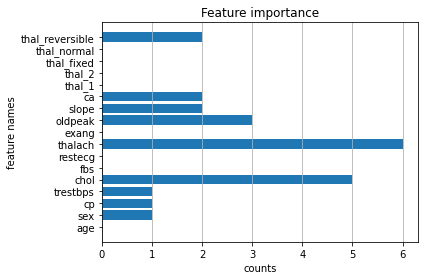

In [329]:
splitting_data = tree10.feature_values
f_index, f_counts = np.unique(splitting_data, return_counts=True)
feature_importance = np.zeros(x_train.shape[1])
for i, j in enumerate(f_counts):
    feature_importance[f_index[i]] = j
x_pos = [i for i, _ in enumerate(feature_importance)]

plt.title('Feature importance')
plt.barh(x_pos, feature_importance)
plt.ylabel('feature names')
plt.xlabel('counts')
plt.xticks(np.arange(max(f_counts)+1))
plt.yticks(x_pos, feature_names)
plt.gca().grid(axis='x', which='major')
plt.tight_layout()
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [330]:
class Adaboost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_estimators):
            clf = DecisionTree()
            clf.fit(X, y)
            min_error = float("inf")
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [331]:
clf = Adaboost(n_estimators=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = accuracy(y_test, y_pred)
print(f'n_estimators = {clf.n_estimators}') 
print("acc:", acc)

n_estimators = 10
acc: 0.74


In [332]:
clf = Adaboost(n_estimators=100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
acc = accuracy(y_test, y_pred)
print(f'n_estimators = {clf.n_estimators}')
print("acc:", acc)

n_estimators = 100
acc: 0.74


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [348]:
class RandomForest:
    def __init__(
        self, n_estimators, max_depth, max_features, classifier=True, criterion="entropy", boostrap=True,
    ):
        """
        An ensemble (forest) of decision trees where each split is calculated
        using a random subset of the features in the input.
        Parameters
        ----------
        n_estimators : int
            The number of individual decision trees to use within the ensemble.
        max_depth: int or None
            The depth at which to stop growing each decision tree. If None,
            grow each tree until the leaf nodes are pure.
        max_features : int
            The number of features to sample on each split.
        classifier : bool
            Whether `Y` contains class labels or real-valued targets. Default
            is True.
        criterion : {'entropy', 'gini', 'mse'}
            The error criterion to use when calculating splits for each weak
            learner. When ``classifier = False``, valid entries are {'mse'}.
            When ``classifier = True``, valid entries are {'entropy', 'gini'}.
            Default is 'entropy'.
        """
        self.trees = []
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.criterion = criterion
        self.classifier = classifier
        self.boostrap = boostrap

    def fit(self, X, Y):
        """
        Create `n_estimators`-worth of bootstrapped samples from the training data
        and use each to fit a separate decision tree.
        """
        self.trees = []
        for _ in range(self.n_estimators):
            if self.boostrap:
                X_samp, Y_samp = bootstrap_sample(X, Y)
            else:
                X_samp, Y_samp = X, Y
            tree = DecisionTree(
                max_features=self.max_features,
                max_depth=self.max_depth,
                criterion=self.criterion,
                classifier=self.classifier,
            )
            tree.fit(X_samp, Y_samp)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict the target value for each entry in `X`.
        Parameters
        ----------
        X : :py:class:`ndarray <numpy.ndarray>` of shape `(N, M)`
            The training data of `N` examples, each with `M` features.
        Returns
        -------
        y_pred : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            Model predictions for each entry in `X`.
        """
        tree_preds = np.array([[t._traverse(x, t.root) for x in X] for t in self.trees])
        print("Random forest")
        print(f'n estimators = {self.n_estimators}')
        print(f'max features = {self.max_features}')
        print(f'boostrap     = {self.boostrap}')
        print(f'criterion    = {self.criterion}')
        print(f'max depth    = {self.max_depth}')
        return self._vote(tree_preds)

    def _vote(self, predictions):
        """
        Return the aggregated prediction across all trees in the RF for each problem.
        Parameters
        ----------
        predictions : :py:class:`ndarray <numpy.ndarray>` of shape `(n_estimators, N)`
            The array of predictions from each decision tree in the RF for each
            of the `N` problems in `X`.
        Returns
        -------
        y_pred : :py:class:`ndarray <numpy.ndarray>` of shape `(N,)`
            If classifier is True, the class label predicted by the majority of
            the decision trees for each problem in `X`. If classifier is False,
            the average prediction across decision trees on each problem.
        """
        if self.classifier:
            out = [np.bincount(x).argmax() for x in predictions.T]
        else:
            out = [np.mean(x) for x in predictions.T]
        return np.array(out)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [341]:
rf = RandomForest(
                n_estimators=10,
                max_depth=None,
                max_features=int(np.ceil(np.sqrt(x_train.shape[1]))),
                criterion='gini',
                boostrap=True
            )
rf.fit(x_train, y_train)
inference = rf.predict(x_test)
acc = accuracy(y_test, inference)
print("acc", acc)
print("======================")

Random forest
n estimators = 10
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc 0.75


In [347]:
rf = RandomForest(
               n_estimators=100,
               max_depth=None,
               max_features=int(np.ceil(np.sqrt(x_train.shape[1]))),
               criterion='gini',
               boostrap=True
           )
rf.fit(x_train, y_train)
inference = rf.predict(x_test)
acc = accuracy(y_test, inference)
print("acc", acc)
print("======================")

Random forest
n estimators = 100
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc 0.79


In [355]:
rf = RandomForest(
                n_estimators=10,
                max_depth=None,
                max_features=int(np.ceil(np.sqrt(x_train.shape[1]))),
                criterion='gini',
                boostrap=True
            )
rf.fit(x_train, y_train)
inference = rf.predict(x_test)
acc = accuracy(y_test, inference)
print("acc", acc)
print("======================")

Random forest
n estimators = 10
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc 0.79


In [356]:
rf = RandomForest(
                n_estimators=10,
                max_depth=None,
                max_features=x_train.shape[1],
                criterion='gini',
                boostrap=True
            )
rf.fit(x_train, y_train)
inference = rf.predict(x_test)
acc = accuracy(y_test, inference)
print("acc", acc)
print("======================")

Random forest
n estimators = 10
max features = 17
boostrap     = True
criterion    = gini
max depth    = None
acc 0.74


### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [357]:
from sklearn.metrics import accuracy_score

In [474]:
rf = RandomForest(
                n_estimators=10,
                max_depth=None,
                max_features=x_train.shape[1],
                criterion='gini',
                boostrap=True
            )
rf.fit(x_train, y_train)
inference = rf.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, inference))

Random forest
n estimators = 10
max features = 17
boostrap     = True
criterion    = gini
max depth    = None
Test-set accuarcy score:  0.8
Test-set accuarcy score:  0.85


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

# Result:
## Decision Tree
* Decision trees are easy to understand and interpret, can be visually analyzed, and rules can be easily extracted.
* Can handle both nominal and numerical data.
* It's better suited to handle samples with missing attributes.
* Decision Tree is ability to handle irrelevant features.
* Relatively fast running speed when testing datasets.
* It can produce feasible and effective results for large data sources in a relatively short period of time.

## Adaboost
* Adaboost is good use of weak classifiers for cascading.
* The possibility of using different classification algorithms as weak classifiers.
* The high accuracy of AdaBoost.
* The weights of each classifier fully considered by AdaBoost compared to the bagging algorithm and Random Forest algorithm.

## Random forest
* The underlying algorithm of the random forest is based on the CART algorithm, so it can handle both categorical and continuous data.
* For most of the data, the random forest algorithm has a high accuracy of the proposed results.
* It accepts high-dimensional feature data.